In [2]:
import jax
import basix
import numpy as np
from typing import Iterable, Union
from basix import CellType, ElementFamily, LagrangeVariant
import jax.numpy as jnp
import jax_pn
from jax.experimental import sparse
from jax_pn.ADPN import NSettings
from jax_pn.FEM1D import compute_local_matrices
%load_ext autoreload
%autoreload 2

In [3]:
jax.devices()
from jax import config
config.update("jax_enable_x64", True)

In [11]:
lagrange    = basix.create_element(ElementFamily.P, CellType.interval, degree= 5, lagrange_variant= LagrangeVariant.gll_warped)
N_max = 3
elements_per_cm = 10
regions = [
    (2.0, [20.0], np.array([[[0.0]]]), [20.0]),
    (1.0, [1.0],  np.array([[[0.0]]]),  [0.0]),
    (2.0, [0.0],  np.array([[[0.0]]]),  [0.0]),
    (1.0, [1.0],  np.array([[[0.9]]]), [1.0]),
    (2.0, [1.0],  np.array([[[0.9]]]), [0.0]),
]
dpn_prob = jax_pn.PN.PN_Problem.from_regions_per_cm(regions, elements_per_cm, N_max, lagrange, L_scat=0)
n_groups = 1

mass_matrix, streaming_matrix = compute_local_matrices(lagrange)

settings = NSettings(n_groups, N_max + 1, dpn_prob.n_global_dofs, len(dpn_prob.nodes) - 1, dpn_prob.dof_matrix, dpn_prob.dof_matrix.shape[1], mass_matrix, streaming_matrix, dpn_prob.nodes)


adpn = jax_pn.ADPN.ADPN_Problem.from_regions_per_cm(regions, elements_per_cm, N_max, lagrange, L_scat=0)

A, b = adpn.Assemble_Single_Energy_Group(0, "vacuum")





In [17]:
import scipy.sparse
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
def bcoo_to_scipy(bcoo_mat):
    data = bcoo_mat.data
    coords = bcoo_mat.indices
    shape = bcoo_mat.shape
    
    # coords shape: (nnz, 2), split into rows and cols
    rows = coords[:, 0]
    cols = coords[:, 1]
    
    # Convert JAX arrays to NumPy arrays
    data_np = data.copy()  # or data.to_py() if needed
    rows_np = rows.copy()
    cols_np = cols.copy()
        
    return scipy.sparse.coo_matrix((data_np, (rows_np, cols_np)), shape=shape).tocsr()

ajax = bcoo_to_scipy(A)
bjax = bcoo_to_scipy(b)

apn      = dpn_prob.assemble_multigroup_system('none',1)[0][:, :]
bpn      = dpn_prob.assemble_multigroup_system('none',1)[1][:, :]




print(np.max(bpn - bjax))

1.1102230246251565e-16


In [ ]:
left_dof = 0
right_dof = len(dpn_prob.nodes) - 1

def check_marshak(settings, u, left_dof, right_dof):
    left_coeff_matrix  = jax_pn.PN.legendre_coeff_matrix(settings.n_moments, 0, 1)
    right_coeff_matrix = jax_pn.PN.legendre_coeff_matrix(settings.n_moments, -1, 0)

    for enforce_i in range(1, settings.n_moments, 2): # number of boundary conditions = group * len(range(1, settings.n_moments, 2))            
        enforce_total = 0
        for l in range(settings.n_moments):              
            left_idx = global_index_PN(settings.n_moments, settings.n_global_dofs, 0, l, right_dof)  # group is fixed to 0 for now
            enforce_total += u[left_idx] * right_coeff_matrix[enforce_i, l] * (2 * l + 1)

            
        print(enforce_i, enforce_total)

check_marshak(settings, ujax, left_dof, right_dof)
check_marshak(settings, upn, left_dof, right_dof)

1 6.658486357244279e-19
3 1.734723475976807e-17
1 6.832047831329302e-18
3 -1.9081958235744878e-17


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1608 stored elements and shape (1608, 1)>
  Coords	Values
  (0, 0)	0.06666666666666654
  (1, 0)	0.13333333333333303
  (2, 0)	0.13333333333333303
  (3, 0)	0.13333333333333303
  (4, 0)	0.13333333333333297
  (5, 0)	0.13333333333333305
  (6, 0)	0.13333333333333305
  (7, 0)	0.13333333333333297
  (8, 0)	0.13333333333333297
  (9, 0)	0.13333333333333297
  (10, 0)	0.13333333333333305
  (11, 0)	0.13333333333333314
  (12, 0)	0.13333333333333297
  (13, 0)	0.13333333333333297
  (14, 0)	0.13333333333333297
  (15, 0)	0.13333333333333297
  (16, 0)	0.13333333333333314
  (17, 0)	0.13333333333333297
  (18, 0)	0.13333333333333297
  (19, 0)	0.13333333333333297
  (20, 0)	0.06666666666666637
  (21, 0)	0.0
  (22, 0)	0.0
  (23, 0)	0.0
  (24, 0)	0.0
  :	:
  (1583, 0)	0.0
  (1584, 0)	0.0
  (1585, 0)	0.0
  (1586, 0)	0.0
  (1587, 0)	0.0
  (1588, 0)	0.0
  (1589, 0)	0.0
  (1590, 0)	0.0
  (1591, 0)	0.0
  (1592, 0)	0.0
  (1593, 0)	0.0
  (1594, 0)	0.0
  (159

/tmp/ipykernel_31376/977734821.py:4: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  upn = spsolve(apn, bpn)


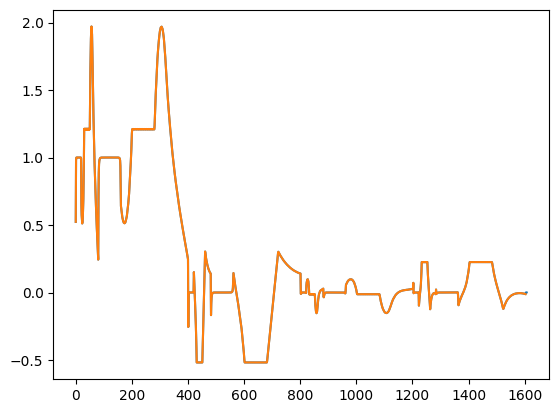

In [ ]:
ujax = spsolve(ajax, bjax)
plt.plot(ujax)

upn = spsolve(apn, bpn)
plt.plot(upn)
print(bjax, bpn)


In [ ]:
print(np.nanmax((apn - ajax[:-4, :-4])/apn))

stupid_indices = np.where((apn - ajax[:-4, :-4])/apn > 1e-2)

print(ajax[stupid_indices])
print(apn[stupid_indices])



0.14285714285714285
[[-1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16
  -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -1.665